In [1]:
!pip install matplotlib

In [2]:
import os
import sys
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print("done")
print(device)

done
cpu


In [3]:
os.getcwd()

'/workspace'

In [4]:
HOMEDIR = os.getcwd()
if "jovyan" in HOMEDIR:
    HOMEDIR = "/home/jovyan/sivtsov/graph_agent"

In [5]:
# crutch for code visibiltiy
sys.path.append(HOMEDIR)

In [6]:
STARPU_HOME = HOMEDIR

# Inspect

here you can dump whole graph, to see how it looks like. It is traced from nntile model (which created from pytorch). So operations should be as in original model (there are tests)

In [7]:
import os
import json
from subprocess import Popen, PIPE
from simulator.nnt_graph_sched_utils import (
    BufferizedIterator, 
    StreamGraphLinesCatcher,
    GraphParser,
    SchedulerTaskGraph,
    TimingsParser,
    PrioritySerializer
)

In [8]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

In [9]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_2_small_layers.json"
ncpus = 1
ncuda = 0
niters = 1
manual_sampling = False

verbose = True

gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=False, starpu_home=STARPU_HOME)

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 1 --ncuda 0 --niters 1
Process pid: 4087


In [10]:
_ = gr.skip_initialization_routine()
graph_init = gr.next()

In [11]:
# https://graphviz.org/
gi_gv = graph_init.to_graphviz()

In [12]:
gi_gv.render(f"{HOMEDIR}/small.dot")

'/workspace/small.dot.pdf'

# Slice the graph

For better convergence, debug and replay buffer purposes, you have the ability to provide slice indicies for graph

Note, you should use interactive mode 

In [13]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_2_small_layers.json"
ncpus = 4
ncuda = 0
niters = 1
manual_sampling = True

verbose = True

gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=False, starpu_home=STARPU_HOME)

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 8 --ncuda 0 --niters 1 --manual_sampling
Process pid: 4096


In [14]:
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations

141

In [15]:
_ = gr.skip_initialization_routine()

In [16]:
graph_slice = gr.next([50,60])

In [17]:
# note that where are actually also initialization ops 
len(graph_slice.nodes)

14

# Collect statistics

First, you need to simulate graph multiple times to collect starpu statistics (nntile based on starpu)   
It will give you timings for every operation in graph

Note, they are statistically collected and will not be updated during next simulations runs. So you can't train on them. 

In [21]:
# file = f"{HOMEDIR}/graph_tracer/traced_graph_16_layers.json"
# ncpus = 4
# ncuda = 0
# niters = 25
# manual_sampling = False

# verbose = True

# gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
# gr.run(interactive=False, collect_metrics=True, starpu_home=STARPU_HOME)
# gr.p.wait()

In [22]:
# # But if all iterations completed - should be fine
# gr.stderr_iter.buffer[-50:]

# Agent

here I suggest you to decouple some logic   

In [23]:
brahch_num:int = 10
max_height = 32
max_gr_width:int = brahch_num * max_height
num_device:int  = ncpus + ncuda
device_metr:int = 1
num_group_device = num_device
num_to_mask = []
for i in range(num_device):
    num_to_mask.append([0 for i in range(num_device)])
    num_to_mask[-1][i] = 1
#num_to_mask.append([1 for i in range(num_device)])
    

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 2048)
        self.layer2 = nn.Linear(2048, 1024)
        self.layer3 = nn.Linear(1024, 1024)
        self.layer4 = nn.Linear(1024, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)



In [24]:
def initialize():
    name_op_to_id = {}
    gr = GraphRunner(f"{HOMEDIR}/graph_tracer/traced_graph_16_layers.json", ncpus, ncuda, 1, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
    gr.run()
    print(gr)
    _ = gr.skip_initialization_routine()
    graph = gr.next()
    for i, (_, n) in enumerate(graph.nodes.items()):
      if n.name != 'NULL':
        name_op_to_id[n.name] = -1
    id:int = 0
    for i, (_, n) in enumerate(graph.nodes.items()):
        if n.name != 'NULL':
            if (name_op_to_id[n.name] == -1):
                name_op_to_id[n.name] = id
                id += 1
    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()
    return [id, name_op_to_id]
[col_ops, name_op_to_id] = initialize()
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.01
EPS_END = 0.00001
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
NODE_METRIKS = 4
len_operations_data:int = col_ops + NODE_METRIKS
SIZE_BACKET = 30
MEMORY_SIZE = 10000
EPOCH_BEFORE_BEST_REC = 20

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_32_layers.json --ncpus 8 --ncuda 0 --niters 1 --manual_sampling
Process pid: 4109
n_nodes: 2095 serialized: 1
Wait timings
Compute timings: t_begin=24944257418776, t_end=24956864677094, delta_ms=12607.258318


In [25]:
class graph_slice:
  free_nodes = []
  cnt_in = {}
  deeps = {}
  gr = []
  fr_t = []
  allgr = []
  cur_prio = int(1e9)
  load_of_dev = []
  
  def __init__(self, gr, last_prios = None, need_random = False) -> None:
      global num_device
      graph = gr.next()
      self.free_nodes = []
      self.cnt_in = {}
      self.load_of_dev = [0] * num_device
      self.sum_time = 0
      self.sum_dim = 0
      self.last_prios = last_prios
      self.adress_to_ind = {}
      print(len(graph.nodes.items()))
      for i, (_, n) in enumerate(graph.nodes.items()):
        self.adress_to_ind[n.addr] = i
        if n.name != 'NULL':
            self.cnt_in[n.addr] = len(n.inc)
            if (len(n.inc) == 0):
              self.free_nodes.append(n.addr)
      self.cur_prio = int(1e9)
      self.gr = graph.nodes
      for el in self.free_nodes:
          self.deeps[el] = 0
      self.fr_t = gr
      self.allgr = graph
      self.last_measure = 0
      self.dlt = 0
      for i, (_, n) in enumerate(graph.nodes.items()):
        if (need_random):
            self.last_prios.append(np.random.randint(1, 10000000))
        if n.name != 'NULL':
            self.sum_time += self.gr[n.addr].perfmodels[0].length_mcs
      #print(self.last_prios)
  def make_decision(self, v:int, mask_dev) -> bool:
      if (v >= len(self.free_nodes)):
          return False
      #print(v, mask_dev)
      v = self.free_nodes[v]
      self.gr[v].prio = self.cur_prio
      self.last_prios[self.adress_to_ind[v]] = self.cur_prio
      self.gr[v].device_affinity = mask_dev
      self.cur_prio-=1
      
      self.free_nodes.remove(v)
      prob_used = []
      for  i in range(num_device):
          prob_used.append(i)
      assert(len(prob_used) > 0)
      for el in prob_used:
          self.load_of_dev[el] += (self.gr[v].perfmodels[0].length_mcs / self.sum_time / len(prob_used))
      for el in  self.gr[v].out:
        if (self.gr[el].name != 'NULL'):
            self.cnt_in[el]-=1
            if (self.cnt_in[el] == 0):
              self.deeps[el] = 0
              for u in self.gr[el].inc:
                  self.deeps[el] = max(self.deeps[el], self.deeps[u] + 1)
              self.free_nodes.append(el)
      return True

  def get_el_data(self, v:int, l:int, res):
    global name_op_to_id, col_ops
    res[l + name_op_to_id[self.gr[v].name]] = 1
    res[l + col_ops] = self.deeps[v] / len(self.gr)
    res[l + col_ops + 1] = len(self.gr[v].out) / len(self.gr)
    res[l + col_ops + 2] = self.gr[v].perfmodels[0].length_mcs/ self.sum_time
  def get_dev_data(self, j:int, l:int, res):
    res[l] = self.load_of_dev[j]

  def get_croppped_verticles(self):
    if len(self.free_nodes) == 0:
        return []
    vertecle_by_height = []
    for el in self.free_nodes:
        vertecle_by_height.append([self.deeps[el], -self.last_prios[self.adress_to_ind[el]], el])
    vertecle_by_height = sorted(vertecle_by_height)
    temp = []
    col = 0
    curh = vertecle_by_height[0][0]
    for el in vertecle_by_height:
        if (curh != el[0]):
            col = 0
            curh = el[0]
        if (col < brahch_num):
            col += 1
            temp.append(el[2])
    return temp
  def get_state_vector(self):
    global max_gr_width, len_operations_data, col_ops
    res = np.zeros(max_gr_width * len_operations_data + num_device * device_metr)
    l = 0;
    
    for el in self.get_croppped_verticles():
      self.get_el_data(el, l, res)
      l += len_operations_data
    for j in range(num_device):
      self.get_dev_data(j, l, res)
      l += device_metr
    return res
  def get_timings(self):
    assert(len(self.free_nodes) == 0)
    self.allgr.nodes = self.gr
    self.fr_t.serialize_priorities(self.allgr)
    cur_t = self.fr_t.wait_get_timings()
    print(self.last_measure)
    print(cur_t)
    self.dlt = self.last_measure - cur_t
    self.last_measure = cur_t
    return cur_t
  def get_time(self, v:int):
    return (-self.last_measure * self.gr[v].perfmodels[0].length_mcs/ self.sum_time)


In [26]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
def gen_pair(sz:int):
    res = np.random.randint(0, sz, 2)
    if (res[0] > res[1]):
        swap(res[0], res[1])

In [28]:
class BaselineAgent:
    def __init__(self, strategy="random", len_operations_data = 0, max_gr_width = 0, num_group_device = 0,num_to_mask =[],  device="cpu"):
        """
        here you can store actual model
        and history of this agent (maybe resent, not whole)
        """
        self.strategy = strategy
        self.device = device
        self.policy_net = DQN(len_operations_data * max_gr_width + num_device * device_metr, max_gr_width * num_group_device).to(device)
        self.target_net = DQN(len_operations_data * max_gr_width + num_device * device_metr, max_gr_width * num_group_device).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.memory = ReplayMemory(MEMORY_SIZE)
        self.steps_done = 0
        self.num_group_device = num_group_device
        self.num_to_mask = num_to_mask
    def select_action(self, state, width:int = max_gr_width):
        assert(width < max_gr_width)
        sample = random.random()
        global EPS_END, EPS_START, EPS_DECAY
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                res = self.policy_net(state).max(1).indices.view(1, 1)
                return res
        else:
        #print("rd")
            return torch.tensor([[random.randint(0, width * num_group_device - 1)]])
    def get_values(self, action):
        res:int = action[0][0]
        msk = self.num_to_mask[res % self.num_group_device]
        return [res // self.num_group_device, msk]

    def schedule(self, graph):
        """
        Here you just schedule train
        Don't do expensive grapdient/state computations, just simulation step
        """
        if self.strategy=="dynamic":
            custom_dynamic_policy(i, graph, strategy=self.device)
            return
        elif self.strategy=="random":
            custom_random_policy(i, graph, strategy=self.device)
            return
        elif self.strategy == "neural":
            pass
        else:
            return
        my_slice = graph
        state = torch.tensor(my_slice.get_state_vector(), dtype=torch.float32, device=self.device).unsqueeze(0)
        self.frc = []
        good_steps:int = 0
        steps = 0
        pred = []
        for t in count():
            # print("trouble", my_slice.free_nodes, pred)
            assert my_slice.free_nodes != pred, "fffffff"
            pred = my_slice.free_nodes.copy()
            if (len(my_slice.free_nodes) == 0):
                break;
            steps += 1
            action = self.select_action(state=state, width = len(my_slice.get_croppped_verticles()))
            assert(action < num_group_device * max_gr_width)
            [v, msk] = self.get_values(action)
            #msk = [1,1,1,1]
            #print(v, msk)
            tm = -1
            if (len(my_slice.free_nodes) > v):
                tm = my_slice.free_nodes[v]
            good:bool = my_slice.make_decision(v, msk)
            #print(good)
            nxt_state = torch.tensor(np.zeros(len_operations_data * max_gr_width + num_device * device_metr), dtype=torch.float32, device=self.device).unsqueeze(0)
            if (good):
                good_steps += 1
                nxt_state = torch.tensor(my_slice.get_state_vector(), dtype=torch.float32, device=device).unsqueeze(0)
                self.frc.append([state, action, nxt_state, tm])
            else:
                self.memory.push(state, action, nxt_state, torch.tensor(-1, dtype=torch.float32, device=device).unsqueeze(0))
                action = torch.tensor([[random.randint(0, len(my_slice.free_nodes) * num_group_device - 1)]])
                [v, msk] = self.get_values(action)
                #msk = [1 for i in range(num_group_device)]
                tmp = my_slice.make_decision(v, msk)
                assert tmp, "random op should be good"
                nxt_state = torch.tensor(my_slice.get_state_vector(), dtype=torch.float32, device=device).unsqueeze(0)
            state = nxt_state
        print("good=", good_steps / steps)
        return good_steps / steps

class AgentTrainer:
    def __init__(self,agent,  BATCH_SIZE = 128):
        # self.optimizer = optimizer
        # self.replay_buffer = replay_buffer
        self.BATCH_SIZE = BATCH_SIZE
        self.optimizer = optim.Adam(agent.policy_net.parameters(), lr=LR, amsgrad=True)
    
    def step(self,agent, timing, device="cpu"):
        """
        Called after getting timings from your agent decision
        Here you can maintain optimizer states, compute grads, backpropagate and so on
        Probably - here can be stored state for RL algos like replay buffer
        """
        if (len(agent.memory) < self.BATCH_SIZE):
            return
        transitions = agent.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = agent.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(), 100)
        self.optimizer.step()
        global TAU
        agent.target_net_state_dict = agent.target_net.state_dict()
        agent.policy_net_state_dict = agent.policy_net.state_dict()
        for key in agent.policy_net_state_dict:
            agent.target_net_state_dict[key] = agent.policy_net_state_dict[key]*TAU + agent.target_net_state_dict[key]*(1-TAU)
        agent.target_net.load_state_dict(agent.target_net_state_dict)

# Runner


In [29]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

from interpretator import (
    get_subset_inds
)

import json
import numpy as np

2025-06-22 16:55:42.602746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
def get_etalon(file, gr):
    agent = BaselineAgent(strategy="dynamic", device="cpu" if ncuda==0 else "cuda")
    trainer = AgentTrainer(agent)
    timings_dynamic = []

    for i in range(5):
        # inds = get_subset_inds(rng, total_operations)
        inds = "all" # just use this if you want whole graph
        print(f"{i=} {inds=}")
        graph = gr.next()

        # print("Nodes: ", len(graph.nodes))

        agent.schedule(graph)

        gr.serialize_priorities(graph)
        timings = gr.wait_get_timings()

        trainer.step(agent, timings)
    
        timings_dynamic.append(timings)
    return timings_dynamic[-1]
    

In [32]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_2_small_layers.json"
niters = 10
manual_sampling = True

verbose = True
# verbose = False

In [33]:
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations

141

In [34]:
agent = BaselineAgent(strategy="dynamic", device="cpu" if ncuda==0 else "cuda")
trainer = AgentTrainer(agent)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [35]:
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 8 --ncuda 0 --niters 10 --manual_sampling
Process pid: 4126


In [36]:
rng = np.random.default_rng()

In [37]:
timings_dynamic = []

for i in range(gr.niters):
    # inds = get_subset_inds(rng, total_operations)
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    graph = gr.next(inds=inds)

    # print("Nodes: ", len(graph.nodes))

    agent.schedule(graph)

    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()

    trainer.step(agent, timings)
    
    timings_dynamic.append(timings)

i=0 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24965365942253, t_end=24965499158879, delta_ms=133.216626
i=1 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24965508279110, t_end=24965634556966, delta_ms=126.277856
i=2 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24965643067653, t_end=24965775445687, delta_ms=132.378034
i=3 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24965784199401, t_end=24965912456017, delta_ms=128.256616
i=4 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24965921059488, t_end=24966051103706, delta_ms=130.044218
i=5 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24966059599456, t_end=24966179056603, delta_ms=119.457147
i=6 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24966187779548, t_end=24966318694118, delta_ms=130.91457
i=7 inds='all'
n_node

In [38]:
agent = BaselineAgent(strategy="random", device="cpu" if ncuda==0 else "cuda")
trainer = AgentTrainer(agent)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [39]:
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 8 --ncuda 0 --niters 10 --manual_sampling
Process pid: 4139


In [40]:
timings_random = []

for i in range(gr.niters):
    # inds = get_subset_inds(rng, total_operations)
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    graph = gr.next(inds=inds)

    # print("Nodes: ", len(graph.nodes))

    agent.schedule(graph)

    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()

    trainer.step(agent, timings)
    
    timings_random.append(timings)

i=0 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24972692469665, t_end=24972821212322, delta_ms=128.742657
i=1 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24972831408129, t_end=24972965973685, delta_ms=134.565556
i=2 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24972975426028, t_end=24973100946484, delta_ms=125.520456
i=3 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24973110540854, t_end=24973236457512, delta_ms=125.916658
i=4 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24973246091897, t_end=24973371185492, delta_ms=125.093595
i=5 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24973380729688, t_end=24973505534061, delta_ms=124.804373
i=6 inds='all'
n_nodes: 145 serialized: 144
Wait timings
Compute timings: t_begin=24973514937633, t_end=24973635515501, delta_ms=120.577868
i=7 inds='all'
n_nod

In [41]:
print(len_operations_data)
agent = BaselineAgent("neural",len_operations_data,max_gr_width, num_group_device, num_to_mask,  device="cpu" if ncuda==0 else "cuda")
trainer = AgentTrainer(agent)
best_model = None
best_res = 1e14

24


In [42]:

best_res = 1e14

In [44]:
import copy
file = f"{HOMEDIR}/graph_tracer/traced_graph_32_layers.json"
num_episodes = 300
for_gen = GraphRunner(file, ncpus, ncuda, num_episodes+((num_episodes + EPOCH_BEFORE_BEST_REC - 1)//EPOCH_BEFORE_BEST_REC) * 5, True, verbose=verbose, home_dir=HOMEDIR)
for_gen.run()
_ = for_gen.skip_initialization_routine()

BEST_TIME = 0
TRAIN_FOR_TRACE = 20

epi_to_ac = []
epi_to_score = []
last_prios = []
good_prios = []
for i_episode in range(num_episodes):
    tmp = copy.copy(last_prios)
    if (i_episode % EPOCH_BEFORE_BEST_REC == 0):
        BEST_TIME = get_etalon(file, for_gen)
    # Initialize the environment and get its state
    my_slice = graph_slice(for_gen,last_prios, i_episode == 0)
    ac = agent.schedule(my_slice)
    cur_t = my_slice.get_timings()
    epi_to_score.append(cur_t / BEST_TIME)
    epi_to_ac.append(ac)
    if (cur_t / BEST_TIME < best_res and ac > 0.9):
        best_res = cur_t /BEST_TIME
        best_model = copy.deepcopy(agent)
        good_prios = copy.copy(tmp)
    for el in agent.frc:
        reward = torch.tensor(my_slice.get_time(el[3]) / (BEST_TIME), dtype=torch.float32, device=device).unsqueeze(0)
        assert(el[1] < max_gr_width * num_group_device)
        agent.memory.push(el[0], el[1], el[2], reward)
    for  i in range(TRAIN_FOR_TRACE):
        trainer.step(agent = agent, timing = cur_t)
    #print(last_prios)
    #if (COUNT_IT == INFO_SZ):
      #  print("good_st = ", good_steps)
      #  print("normal metric = ", get_timings_policy(5, for_gen) / get_timings_for_acc(5, for_gen))
      #  COUNT_IT = 0
      #  INFO_MEAN = 0
 #       if done:
  #          episode_durations.append(t + 1)
   #         plot_durations()
    #        break

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_32_layers.json --ncpus 8 --ncuda 0 --niters 375 --manual_sampling
Process pid: 4152


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


i=0 inds='all'
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=24996500651702, t_end=25009243848811, delta_ms=12743.197109
i=1 inds='all'
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25009358114193, t_end=25022165843362, delta_ms=12807.729169
i=2 inds='all'
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25022278688591, t_end=25035049730079, delta_ms=12771.041488
i=3 inds='all'
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25035164616184, t_end=25047946996253, delta_ms=12782.380069
i=4 inds='all'
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25048286222144, t_end=25061023262228, delta_ms=12737.040084
2095
good= 0.39369326325848064
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25072009042295, t_end=25084954978788, delta_ms=12945.936493
0
12945.936493
2095
good= 0.45532728141423795
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=25112

KeyboardInterrupt: 

# Look, difference is 1.5%

It is really small, be carefull   
Just because testing graph setup is really small. Graph bigger, and if cant store in gpu - you will start feeling

For now we are not explored yet:
1. Tensor/Pipeline parallelism
2. Heterogenous setup (different gpus)
3. ofloading
4. backward passes and gradient chekpointing

In [45]:
print(best_res)
# agent.policy_net.load_state_dict(torch.load("cifar_fc.pth"))

0.9773021587439592


In [46]:
agent2 = BaselineAgent(strategy="dynamic", device="cpu" if ncuda==0 else "cuda")
trainer = AgentTrainer(best_model)
gr = GraphRunner(file, ncpus, ncuda, 2 * 20, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()
timings_dynamic = []
print(good_prios)
for i in range(gr.niters // 2):
    # inds = get_subset_inds(rng, total_operations)
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    m = graph_slice(gr,good_prios)
    best_model.schedule(m)
    timings = m.get_timings()
    graph = gr.next(inds=inds)

    # print("Nodes: ", len(graph.nodes))

    agent2.schedule(graph)

    gr.serialize_priorities(graph)
    timings2 = gr.wait_get_timings()
    
    timings_dynamic.append(timings / timings2)
print(timings_dynamic)
print(np.mean(timings_dynamic))

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_32_layers.json --ncpus 8 --ncuda 0 --niters 40 --manual_sampling
Process pid: 5219
[999999026, 999999025, 999999934, 999999933, 999999932, 999999931, 999999930, 999999929, 999999928, 999999927, 999999926, 999999925, 999999924, 999999923, 999999922, 999999921, 999999920, 999999919, 999999918, 999999917, 999999916, 999999915, 999999914, 999999913, 999999912, 999999911, 999999910, 999999909, 999999908, 999999907, 999999906, 999999905, 999999904, 999999903, 999999902, 999999901, 999999900, 999999899, 999999898, 999999897, 999999896, 999999895, 999999894, 999999893, 999999892, 999999891, 999999890, 999999889, 999999888, 999999887, 1000000000, 999999999, 999999998, 999999997, 999999996, 999999995, 999999994, 999999993, 999999992, 999999991, 999999990, 999999989, 999999988, 999999987, 999999986, 999999985, 999999984, 999999983, 999999982, 999999981, 999999980, 999999979, 999999978, 999999977, 9999999

KeyboardInterrupt: 

[1.0033046700321402, 0.992164257162638, 0.9967215639501312, 0.9939083798273194, 0.9953448240223377, 0.9862051946860481, 0.99462139448177, 0.9998969374993085, 0.9929912005364162, 0.9920171717808584, 0.9956304064111754, 0.9979963258517408, 0.9940669283734054, 0.994816689537873, 0.9825224642296044, 0.9932791198262342]
0.9940929705130626


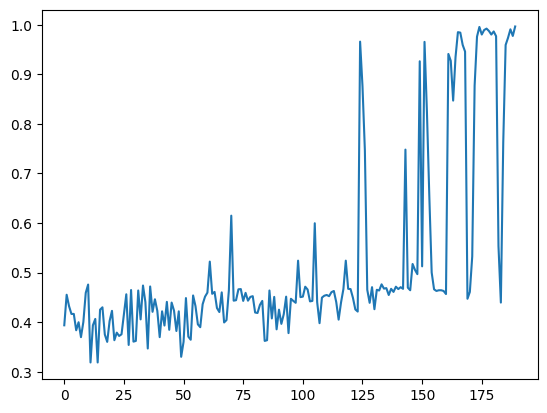

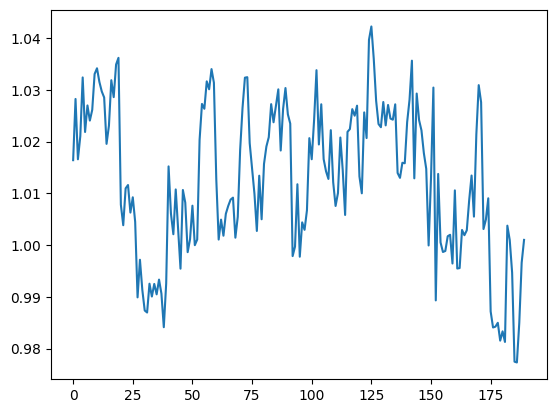

In [47]:
print(timings_dynamic)
print(np.mean(timings_dynamic))
import matplotlib.pyplot as plt
x = [i for i in range(len(epi_to_ac))]
plt.plot(x, epi_to_ac)
plt.show()
plt.plot(x, epi_to_score)
plt.show()

In [ ]:
agent2 = BaselineAgent(strategy="dynamic", device="cpu" if ncuda==0 else "cuda")
trainer = AgentTrainer(agent)
gr = GraphRunner(file, ncpus, ncuda, 2 * 1, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()
timings_dynamic = []

for i in range(gr.niters // 2):
    # inds = get_subset_inds(rng, total_operations)
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    m = graph_slice(gr,last_prios)
    best_model.schedule(m)
    timings = m.get_timings()
    graph = gr.next(inds=inds)

    # print("Nodes: ", len(graph.nodes))

    agent2.schedule(graph)

    gr.serialize_priorities(graph)
    timings2 = gr.wait_get_timings()
    
    timings_dynamic.append(timings / timings2)
print(timings_dynamic)
print(np.mean(timings_dynamic))

## Caveats

In [ ]:
# if metric collection done correctly - on every run you will have filled length_mcs
# it is NOT UPDATING in real time
# it is just statistics collected on collect_metrics=True and not updated since
# they are stored in STARPU_HOME/.starpu/sampling/codelets/*some_number*/
graph.nodes[list(graph.nodes.keys())[50]]